In [1]:
import pandas as pd 
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

sns.set_theme()

In [2]:

from statsmodels.tools.sm_exceptions import  ValueWarning
import warnings

warnings.simplefilter(action = 'ignore', category = ValueWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

In [4]:
df_tea = df.loc[df['Product']=='Tea',['Date','Quantity']].reset_index(drop=True)

In [5]:
split_date = '2023-05-31'

df_train = df_tea[df_tea['Date']<= split_date]
df_test = df_tea[df_tea['Date'] > split_date]

In [6]:
results_aic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='aic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)
results_aic = pm.auto_arima(df_train['Quantity'], trace=True, information_criterion='bic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=1643.325, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=1596.582, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=1594.109, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=1594.218, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=1586.477, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=1583.888, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=1615.046, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=1592.898, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=1593.906, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=1595.237, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=1585.119, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=1605.430, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=1602.884, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=1594.535, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=1594.672, Time=0.27 sec
 ARIMA(3,1

In [12]:
model = ARIMA(df_train['Quantity'], order = (4,1,1)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  151
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -786.451
Date:                Wed, 12 Nov 2025   AIC                           1584.903
Time:                        22:42:57   BIC                           1602.967
Sample:                             0   HQIC                          1592.242
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0749      0.129      0.579      0.562      -0.179       0.328
ar.L2         -0.0034      0.110     -0.031      0.975      -0.219       0.213
ar.L3          0.0319      0.080      0.397      0.6

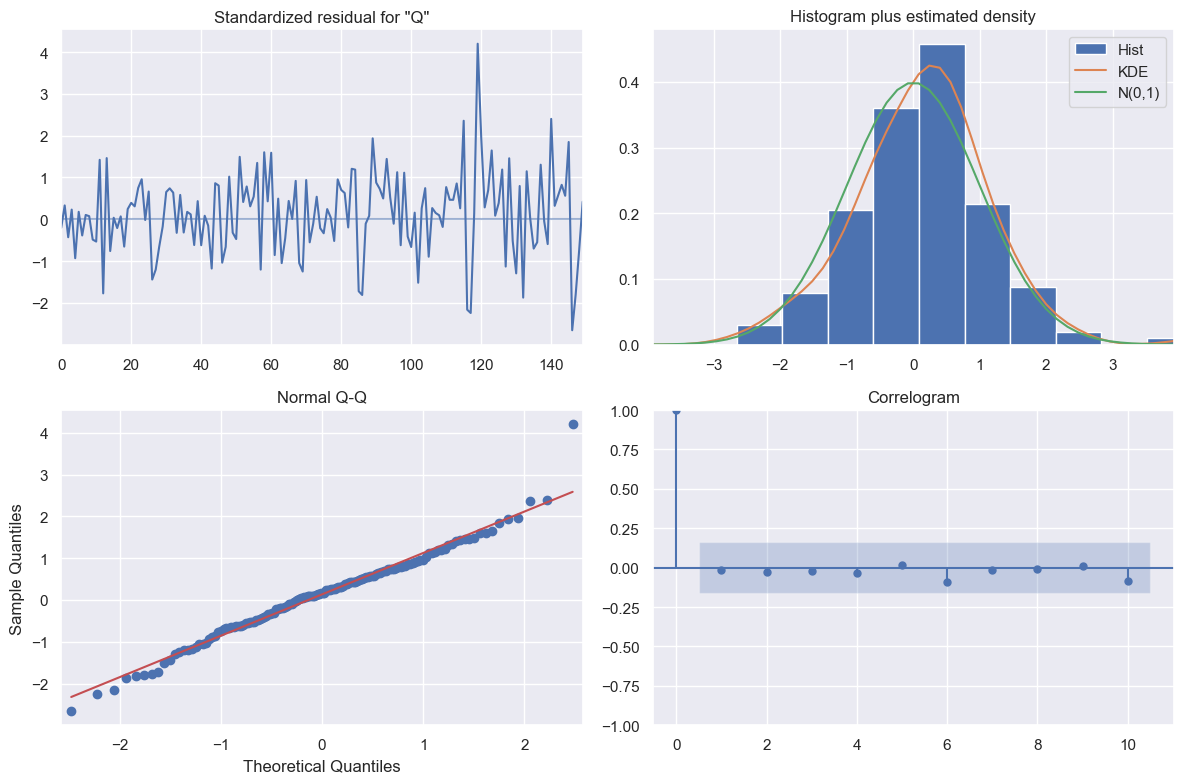

In [13]:
model.plot_diagnostics(figsize = (12,8))
plt.tight_layout()
plt.savefig('Images/Diagnostics/ARMIA_Tea.png')
plt.show()

In [14]:
forecast = model.forecast(steps=len(df_test))
forecast.index = df_test['Date']

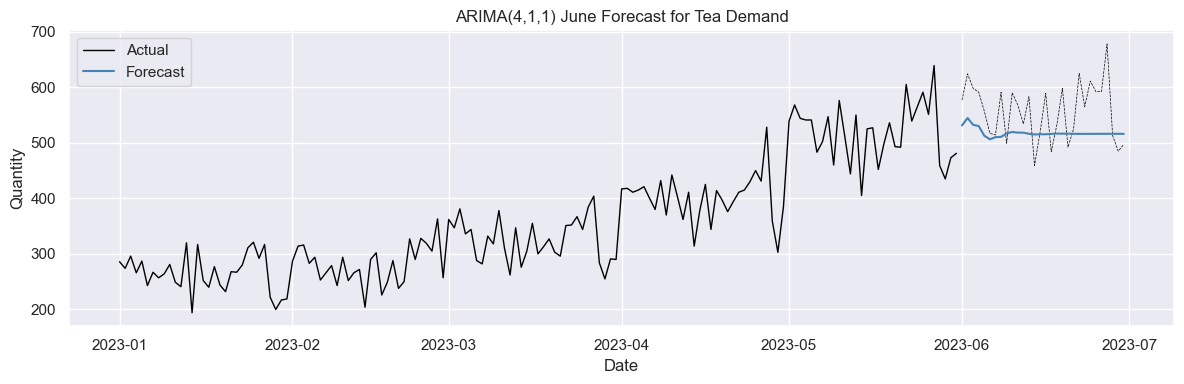

In [17]:
plt.figure(figsize=(12,4))


ax = sns.lineplot(data = df_train,x='Date',y='Quantity', label = "Actual",c='black', linewidth = 1)
ax = sns.lineplot(data = df_test,x='Date',y='Quantity', linestyle = '--', c='black', linewidth = 0.5)
ax = sns.lineplot(x=forecast.index, y=forecast, c='steelblue', label='Forecast')
ax.set(title = 'ARIMA(4,1,1) June Forecast for Tea Demand')

plt.tight_layout()
plt.savefig('Images/Forecasts/Tea_ARIMA.png')

plt.show()

In [16]:
mape = mean_absolute_percentage_error(df_test['Quantity'], forecast) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 8.74%


### Box-Cox ARIMA

In [18]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [19]:
df_train_bc = df_train.copy()

df_train_bc['Transformed'],lam = boxcox(df_train['Quantity'])

df_train_bc

,Date,Quantity,Transformed
0,2023-01-01,286,2.070831
1,2023-01-02,274,2.067311
2,2023-01-03,296,2.073605
3,2023-01-04,266,2.064838
4,2023-01-05,287,2.071115
...,...,...,...
146,2023-05-27,639,2.125833
147,2023-05-28,459,2.105541
148,2023-05-29,435,2.101957
149,2023-05-30,473,2.107509


In [20]:
results_aic_bc = pm.auto_arima(df_train_bc['Transformed'], trace=True, information_criterion='aic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)
results_bic_bc = pm.auto_arima(df_train_bc['Transformed'], trace=True, information_criterion='bic',seasonal=True,start_p=0,max_p=10, start_q=0,max_q=10,stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-884.066, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-935.867, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-938.816, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-932.974, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-942.253, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-947.181, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-915.679, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-940.287, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-936.803, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-935.202, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-925.243, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-926.555, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-936.527, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-928.481, Time=0.13 sec
 ARIMA(3,1,0)(0

In [34]:
model_bc = ARIMA(df_train_bc['Transformed'], order = results_aic_bc.order).fit()
print(model_bc.summary())

                               SARIMAX Results                                
Dep. Variable:            Transformed   No. Observations:                  151
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 480.868
Date:                Thu, 13 Nov 2025   AIC                           -949.735
Time:                        15:32:58   BIC                           -931.671
Sample:                             0   HQIC                          -942.397
                                - 151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1143      0.106      1.076      0.282      -0.094       0.322
ar.L2          0.0590      0.102      0.579      0.562      -0.141       0.258
ar.L3          0.0640      0.081      0.786      0.4

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


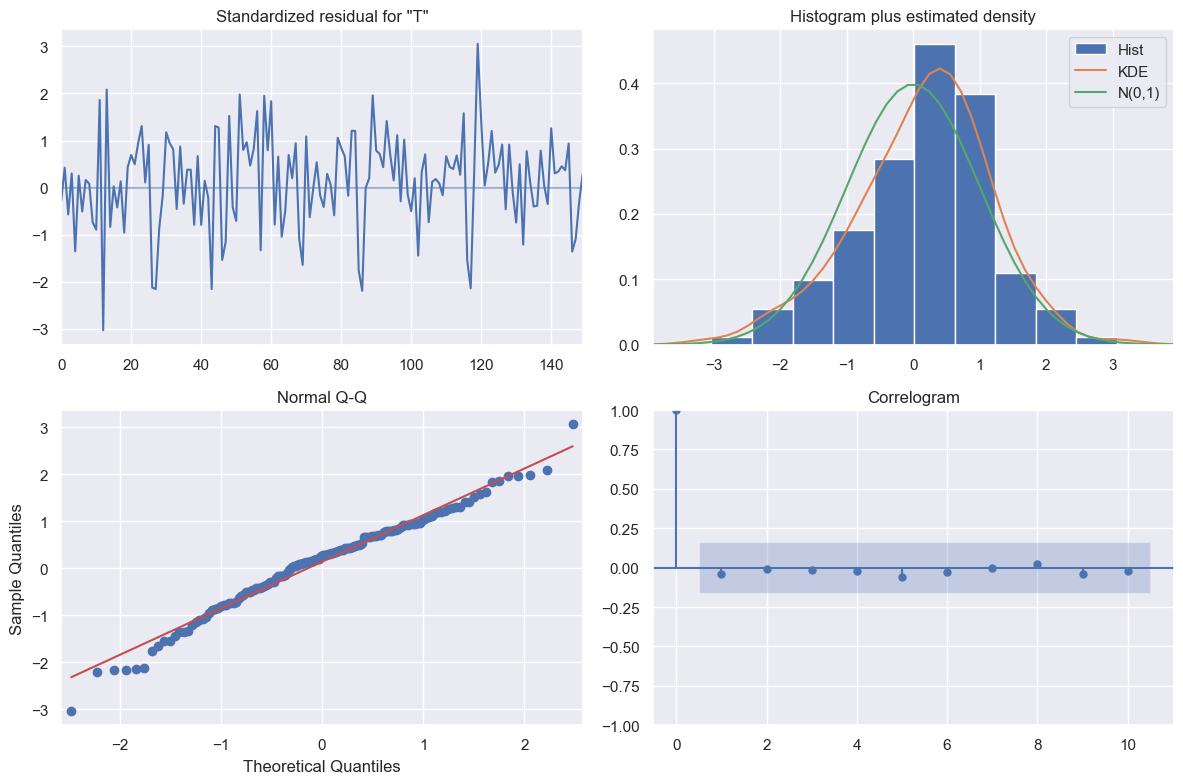

In [22]:
model_bc.plot_diagnostics(figsize = (12,8))
plt.tight_layout()
plt.savefig('Images/Diagnostics/ARMIA_BC_Tea.png')
plt.show()

In [23]:
forecast_bc = model_bc.forecast(steps=len(df_test))
forecast.index = df_test['Date']

In [24]:
forecast_inv_transformed = inv_boxcox(forecast_bc,lam)

forecast_inv_transformed

151    522.805286
152    542.605670
153    531.027088
154    530.476560
155    515.238994
156    506.222967
157    508.095932
158    507.032608
159    511.654463
160    515.472355
161    515.438150
162    516.348259
163    515.026097
164    513.569203
165    513.395556
166    512.885666
167    513.190060
168    513.699453
169    513.804682
170    514.047646
171    514.005938
172    513.841222
173    513.798137
174    513.694667
175    513.684566
176    513.732975
177    513.746578
178    513.787061
179    513.799171
180    513.786629
Name: predicted_mean, dtype: float64

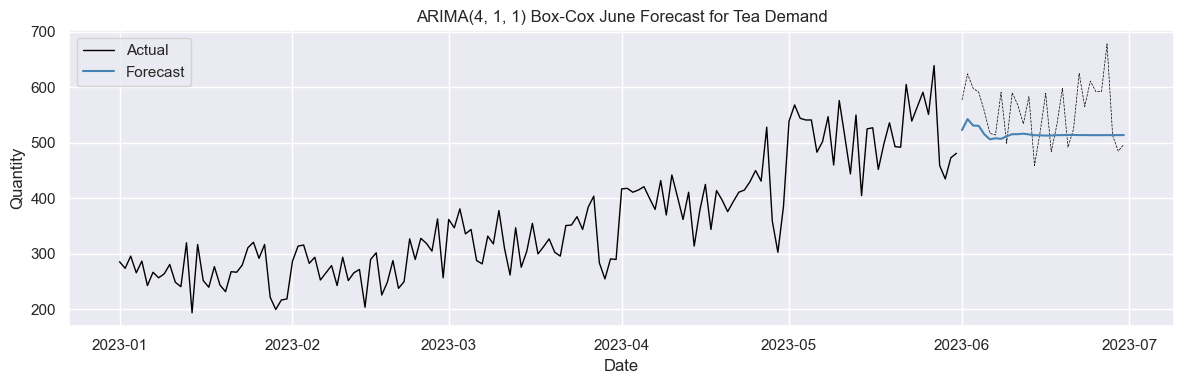

In [35]:
plt.figure(figsize=(12,4))


ax = sns.lineplot(data = df_train,x='Date',y='Quantity', label = "Actual",c='black', linewidth = 1)
ax = sns.lineplot(data = df_test,x='Date',y='Quantity', linestyle = '--', c='black', linewidth = 0.5)
ax = sns.lineplot(x=forecast.index, y=forecast_inv_transformed, c='steelblue', label='Forecast')
ax.set(title = f'ARIMA{results_aic_bc.order} Box-Cox June Forecast for Tea Demand')

plt.tight_layout()
plt.savefig('Images/Forecasts/Coffee_BC_ARIMA.png')

plt.show()

In [26]:
mape_bc = mean_absolute_percentage_error(df_test['Quantity'], forecast_inv_transformed) * 100

print(f"MAPE: {mape_bc:.2f}%")

MAPE: 8.90%
